#Regularisation and Optimisation
This assignment investigates training of CNNs on CIFAR with a goal of maximising accuracy.

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is a dataset with small size (32x32) images and 50k training samsamples.
* It is often used as a "Hello World" type data set to setup a training pipeline. As it is relatively fast to train a network with CIFAR-10, this dataset is also widely used for running comparison or optimisation experiments. For example comparing different networks, regularisation methods or optimisers. (In pytorch the CIFAR-10 dataset is available as a [pytorch dataset](https://pytorch.org/vision/0.18/generated/torchvision.datasets.CIFAR10.html) simplifying loading the dataset.)

The starting point in this assignment is an untrained convolutional neural network.
* You will not modify the structure of the network. (We will discuss network structures in more detail in section 2 of module).
* The network has sufficient capacity (Parameters/FLOPS) to achieve high accuracy.
* The notebook (starting configurataion) will train the model without regularisation and using the SGD optimiser. From inspection of the training/validation accuracy/loss, it will be observed that the network is ovefitting.
* You will improve the performance of the network using regularisation techniques (See below).
* The goal is to use one or several techniques to prevent overfitting and maximse test accuracy.

Regularisation techniques.
* [Data Augmentation using pytorch transforms](https://pytorch.org/vision/0.15/transforms.html)
* Regularisation layers such as [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and [batch normalisation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).

The learning rate also acts as a regulariser, with large learning rates having a regularising effect. You may also include a LR schedule as detailed in the [pytorch optim package](https://pytorch.org/docs/stable/optim.html). The optim package contains several implementations of LR schedules including those detailed in the papers:
* [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186)
* [Super-Convergence: Very Fast Training of Neural
Networks Using Large Learning Rates](https://arxiv.org/pdf/1708.07120)


How to approach this Assignment.
* There are a lot things to try and possible approaches. Keep a table of what you have tried. Apart from recording training and test accuracy, Ensure that you record the key hyperparameters, including optimiser, base learning rate, number of epochs for each run. This makes repeating experiments possible if you want to try a variation.
* Your final submitted notebook should include your best attempt showing training curves and a comment on your approach. (Do not submit a notebook with multiple approaches)


In [496]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad
import matplotlib.pyplot as plt
import numpy as np

import os
from torchinfo import summary
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.nn.utils import clip_grad_norm_

In [497]:
#!pip install torchinfo

In [498]:
#!pip install torchmetrics

In [499]:
#!pip install numpy

In [500]:
#!pip install tensorboard
# url to see the data http://localhost:6006/?darkMode=true#timeseries

In [501]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

torch.manual_seed(42)

if device == 'cuda':
    # this part was added as I noticed with each run i would get a different result
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    print("CuDNN benchmark / deterministic mode ENABLED") # since we have a fixed input of images may as well put the machine to work - faster convolution


Using cuda device
CuDNN benchmark / deterministic mode ENABLED


In [502]:
from torchvision.transforms import autoaugment, InterpolationMode

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def fetch_accuracy(y_true, y_pred):

    acc_A = accuracy_score(y_true, y_pred)
    f1_macro_A = f1_score(y_true, y_pred, average='macro')

    print(f"Model A → Acc: {acc_A:.3f}, Macro-F1: {f1_macro_A:.3f}")

def fetch_train_object(batch_size, num_workers, pin_memory) :

    train_transforms = v2.Compose([
        v2.RandomCrop(32, padding=4, padding_mode='reflect'),
        v2.RandomHorizontalFlip(),
        v2.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0.0),
        v2.ToDtype(torch.float32, scale=True),
        ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    training_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=train_transforms)

    train_dataloader = DataLoader(training_data,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory,
                                  prefetch_factor=4,      # range 2- 8
                                  persistent_workers=True)

    print('Train Samples ',len(train_dataloader.dataset))
    print('Train Batches ',len(train_dataloader))

    return train_transforms, training_data, train_dataloader

def fetch_test_object(batch_size, num_workers, pin_memory):

    test_transforms = v2.Compose([
        v2.ToDtype(torch.float32, scale=True),
        ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    test_data = datasets.CIFAR10(
            root="data",
            train=False,
            download=True,
            transform=test_transforms)

    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=pin_memory,
                                 prefetch_factor=4,      # range 2- 8
                                 persistent_workers=True)

    print('Test Samples ',len(test_dataloader.dataset))
    print('Test Batches ',len(test_dataloader))

    return test_transforms, test_data, test_dataloader

In [503]:
batch_size = 128 # to speed up things  256
num_workers = min(8, os.cpu_count() or 1)
pin_memory = (device == 'cuda')

train_transforms, training_data, train_dataloader = fetch_train_object(batch_size, num_workers, pin_memory)
test_transforms, test_data, test_dataloader = fetch_test_object(batch_size, num_workers, pin_memory)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Train Samples  50000
Train Batches  391
Test Samples  10000
Test Batches  79
Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
Shape of y: torch.Size([128]) torch.int64


In [504]:
#print('Test Samples ',len(test_dataloader.dataset))
#print('Train Samples ',len(train_dataloader.dataset))
#print('Test Batches ',len(test_dataloader))
#print('Train Batches ',len(train_dataloader))

In [505]:
# Output next batch from dataloader
#dataiter = iter(train_dataloader)
#image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

#i=0
#n_plots = 12 # number of plots
#f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

#for image in image_batch[0:n_plots,:,:,:]:
#  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
#  mean = np.array([0.485, 0.456, 0.406])
#  std = np.array([0.229, 0.224, 0.225])
#  disp_image = std * disp_image + mean
#  disp_image = np.clip(disp_image, 0, 1)
#  axarr[i].imshow(disp_image[:,:,:])
#  axarr[i].axis("off")
#  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
#  i = i+1

# Define CNN Model

To define a neural network in PyTorch, we create a class that inherits ([see python inheritance](https://www.w3schools.com/python/python_inheritance.asp))
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the GPU.

A simple CNN is defined using [2D convolution](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [2D max pooling layers](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html). [Relu activiation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) is applied after the convolution layers. The output of the last convolution is [flattened](https://pytorch.org/docs/stable/generated/torch.flatten.html) and [2 linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) (dense) layers applied. Only activiation is applied after the first linear layer. As seen in the next section when setting up our loss function we use the form `_from_logits` so the optimiser will know that softmax activiation needs to be applied. (Alternatively we can directly apply [softmax activiation](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html))

* **You do not need to modify the network architecture**. You can add regularisation layers and adjust the optimisation/learning rate schedule which is a further method of regularisation in later code cells.

In [506]:
# -- model --

In [507]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.simple_cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding='same'),   # by having 2 conv we are looking for more features to extract
            nn.BatchNorm2d(32),
            nn.ReLU(),                             # convert negative to a 1
            nn.Conv2d(32,64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # downsampling
            #nn.Dropout(0.2),                         # on the QA videos you said it should not be added - but I noticed it keeps the gap between training and validation small

            nn.Conv2d(64,64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # downsampling
            #nn.Dropout(0.4),                        # on the QA videos you said it should not be added - but I noticed it keeps the gap between training and validation small

            nn.Conv2d(64,128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2), # downsampling
           # nn.Dropout(0.4),                       # on the QA videos you said it should not be added - but I noticed it keeps the gap between training and validation small

            nn.AdaptiveAvgPool2d(1),                # replace the old ways of VGG with gold standard (brings parameters down from 5k to 1k) - did this before I went over the QA videos
            nn.Flatten(),                           # classification
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),                        # trial and error - started with .2 and at .4 got the improvement ( same for the above )
            nn.Linear(256, 10)
        )

    def forward(self, x):

        logits = self.simple_cnn(x)
        return logits

model = NeuralNetwork().to(device)
summary(model,
        input_size=(1, 3, 32, 32),           # (batch, channels, H, W)
        depth=4,
        device=device
    )

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 64, 16, 16]           36,928
│    └─BatchNorm2d: 2-9                  [1, 64, 16, 16]           128
│    └─ReLU: 2-10                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-11                      [1, 64, 16, 16]           36,928


# Optimisation & Training Loop

For this classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* The SGD (Stocasitc Gradient Descent) Optimiser is provided as a the default training configuration. As the learning rate is fixed, this may not be optimal as training progresses for finding the global minimum.

* Note that you can interrupt the training if it has converged (or failed) and then view the tensorboard curves and also obtain accuracy of the test set (by running the appropriate cells).

* Make sure to run the model call and optimiser call before starting training again to ensure the previous training state is cleared.

[Tensorboard is imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.


In [508]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02,  weight_decay=1e-3, momentum=0.90, nesterov=False)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,          # new_lr = lr * factor
    patience=10
)

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb))


In [509]:
from torch.utils.tensorboard import SummaryWriter
import time

run_name = f"exp_{int(time.time())}"
writer = SummaryWriter(log_dir=f"runs/{run_name}")

Training & Validataion Loop

In [510]:
n_iter =100   # Set how frequently will return loss (must be less than test_size)
n_epochs = 30 # Set total number of epoochs

train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)
num_test_batches = len(test_dataloader)


for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = running_acc = 0.0

    for i, data in enumerate(train_dataloader, 0):

        # input and labels are pushed to the correct device
        inputs, labels = [x.to(device) for x in data]

        outputs = model(inputs)            # forward pass
        loss = loss_fn(outputs, labels)    # compute loss

        loss.backward()                    # compute gradient

        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()                   # update model based on gradient

        running_loss += loss.item()
        running_acc += (outputs.argmax(1) == labels).type(torch.float).sum().item()

        if i % n_iter == n_iter-1:    # Every n mini-batches...

            running_vloss = running_vacc = 0.0

            model.eval()
            for j, vdata in enumerate(test_dataloader, 0):

                vinputs, vlabels = [x.to(device) for x in vdata]

                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)

                running_vloss += vloss.item()
                running_vacc += (voutputs.argmax(1) == vlabels).type(torch.float).sum().item()

            model.train()

            avg_loss = running_loss / n_iter                # Compute loss over n_iter iterations
            avg_acc = 100*running_acc / (n_iter*batch_size) # number of examples computing accuracy over
            avg_vloss = running_vloss / num_test_batches
            avg_vacc = 100*running_vacc / test_size

            scheduler.step(avg_vloss)

            running_loss = 0.0
            running_acc = 0.0

            current_lr = optimizer.param_groups[0]['lr']
            global_step_index = epoch * len(train_dataloader) + i
            writer.add_scalar('Learning Rate', current_lr, global_step_index)
            writer.add_scalars('Loss',     {'Training Loss' : avg_loss, 'Validation Loss' : avg_vloss }, global_step_index)
            print(f"\nStep {global_step_index:03d} — Gap (train-val): {avg_loss-avg_vloss:.4f}")
            writer.add_scalars('Accuracy', {'Training Acc'  : avg_acc, 'Validation Acc'   : avg_vacc  }, global_step_index)

print('Finished Training')

writer.flush()
writer.close()


Step 099 — Gap (train-val): -0.0109

Step 199 — Gap (train-val): -0.1039

Step 299 — Gap (train-val): -0.1631

Step 490 — Gap (train-val): 0.0385

Step 590 — Gap (train-val): -0.1310

Step 690 — Gap (train-val): -0.0156

Step 881 — Gap (train-val): -0.1965

Step 981 — Gap (train-val): 0.0435

Step 1081 — Gap (train-val): 0.0459

Step 1272 — Gap (train-val): 0.0140

Step 1372 — Gap (train-val): -0.0695

Step 1472 — Gap (train-val): -0.0096

Step 1663 — Gap (train-val): -0.0188

Step 1763 — Gap (train-val): -0.0673

Step 1863 — Gap (train-val): -0.0060

Step 2054 — Gap (train-val): -0.0249

Step 2154 — Gap (train-val): -0.0093

Step 2254 — Gap (train-val): -0.0119

Step 2445 — Gap (train-val): -0.1021

Step 2545 — Gap (train-val): -0.0439

Step 2645 — Gap (train-val): -0.1242

Step 2836 — Gap (train-val): -0.0473

Step 2936 — Gap (train-val): -0.0097

Step 3036 — Gap (train-val): -0.0869

Step 3227 — Gap (train-val): -0.1883

Step 3327 — Gap (train-val): -0.0373

Step 3427 — Gap (train-

# Evaluate Model
We will obtain the classification report after final evaluation of the test dataset with the model. A confusion matrix can also be obtained and we will plot a few example images.

In [511]:
import numpy as np

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

store_predictions = []
store_labels = []
model.eval()

for i, data in enumerate(test_dataloader, 0):
    # basic training loop
    input_batch, label_batch = data
    input_batch = input_batch.to(device)

    pred_logit = model(input_batch)
    predictions = torch.argmax(pred_logit,1) # reduce along output dimension
    predictions_np = predictions.to("cpu").numpy()
    label_batch_np = label_batch.numpy()
    if i<num_test_batches-1:
      store_predictions.append(predictions_np)
      store_labels.append(label_batch)

y_pred = np.squeeze(np.reshape(store_predictions,(1,(num_test_batches-1)*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,(num_test_batches-1)*batch_size)))

              precision    recall  f1-score   support

    airplane       0.90      0.93      0.91       998
  automobile       0.96      0.96      0.96       999
        bird       0.93      0.84      0.88       999
         cat       0.81      0.81      0.81       997
        deer       0.88      0.94      0.91      1000
         dog       0.85      0.87      0.86       997
        frog       0.92      0.94      0.93      1000
       horse       0.97      0.91      0.94       997
        ship       0.96      0.95      0.95       997
       truck       0.93      0.95      0.94      1000

    accuracy                           0.91      9984
   macro avg       0.91      0.91      0.91      9984
weighted avg       0.91      0.91      0.91      9984

Model A → Acc: 0.910, Macro-F1: 0.910


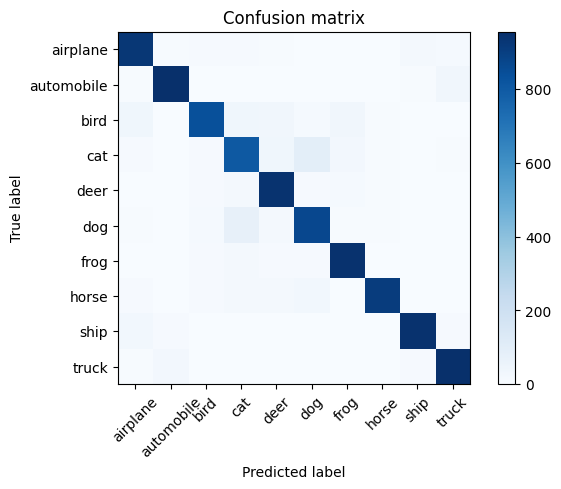

In [512]:
print(classification_report(y_true, y_pred, target_names=classes))
fetch_accuracy(y_true, y_pred)
plot_confusion_matrix(confusion_matrix(y_true, y_pred))

In [513]:
#%tensorboard --logdir=runs --port=6006 --bind_all

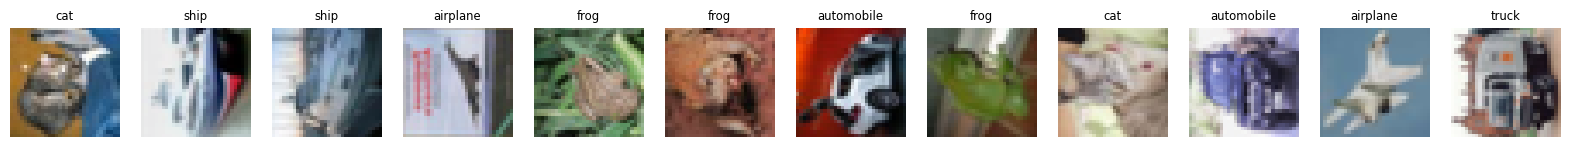

In [514]:
# Output next batch from dataloader
dataiter = iter(test_dataloader)
image_batch, labels_batch = next(dataiter)

# Pass batch through model
model.eval()
image_batch = image_batch.to(device)
pred_logit = model(image_batch)


# Use matplotlib to plot a sample of images
import matplotlib.pyplot as plt
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))


for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  predicted, actual = classes[pred_logit[i,:].argmax(0)], classes[labels_batch[i]]
  color = 'black' if predicted == actual else 'red'
  axarr[i].set_title(predicted,fontsize='small', color=color)
  i = i+1

 # Comments about your Approach

0) I have CUDA runnign

1) I ran the CNN model as it came from the repo, and after running the confusion model and seeing the 5k parameters, bells rung in my head; the fact that we had 5k implied we would overfit (that is why accuracy was at 75%). I changed the tail of the architecture as it was using the old VGG style for the new style (only after I finished the assigment and watched the QA videos I relised we where not supposed to change the architecture - but with each assigment I always like to assume it could be a possible job interview question - so always push the limits and the only way for me to learn is to play around and break things down)

2) After changing the tail of the architecture, the accuracy jumped to 84 %, so the fact that we lowered the number of parameters already proved to be beneficial, without any other change.

3) The last change to the model was to add BatchNorm2d after each convolution, and that brought the accuracy to 87%

4) After the accuracy reached 87% I noticed the gap between the curves was not small, which is why I added Dropout in each block in the model to stop the model from memorising. I started with 0.2 and then updated the value by .1 at a time ( After I finished the assignment and I was about to leave it at 88% - I went over the QA videos, the hint was not to add it - but it did help me to close the gap between the curves - in the end I commented the code for my own reference )

5) After changing the model, I went for the data augmentation, RandomHorizontalFlip was first, and that helped to close the gap between the curves, but the Loss curve was still not closing. That is why I added the gradient clipping to force the Loss curve to close.

6) I was stuck at 83% so I increased the epochs to 30 (I did not want to increase the epochs to a significant number, as that adds issues like over learning, so 30 sounded reasonable)

7) RandomCrop and RandomErasing did help to push the result to 88 - 89 %, the values used were standard (did not spend time tuning them)

8) After each run, the values were jumping, so that annoyed me a lot, as I had no idea if my changes were consistent (that is why I added the magic 42 number as the seed)

9) I spent a day running a custom grid search algorithm :) - as I was sure for other architectures we use grid search for tuning hyper-parameters, why not for the CNN

9.1) The results were mixed, so I abandoned that strategy; however, it did help me to lock in the parameters for SGD

10) For ReduceLROnPlateau, the patience of 10 increased the accuracy value

11) Any other data augmentation decreased the accuracy, which is why I did not add any more operations.

12) As I was about to submit the assignment with an accuracy of 88%, I looked at my weight_decay at 1e-4 and something in my head clicked (after looking also at the graphs), and I decided to change the value to 1e-3, and that jumped the accuracy to 91%. I also commented out all the Dropout changes in each model block, since they didn't add any benefit, except for the last block. .4 is the magic number.

13) I increased the epoch to 40 and above, and it made no difference